<a href="https://colab.research.google.com/github/sorawit27/Konane/blob/main/LSTM_Stock_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to LSTM Stock Forecast!
In this project, we will look at a total of nine different stock indices and use LSTM to try to predict its future prices.

We start by checking that all libraries are added and are of appropriate versions

In [101]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import pandas as pd
import os
from pathlib import Path
!pip install chart_studio
import plotly.express as px

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# install data reader to read stock data from Yahoo Finance
!pip install pandas_datareader
from pandas_datareader import data as pdr

Now we import historical stock data from Yahoo Finance for three major banks in Thailand: Kasikorn Bank, Siam Commercial Bank, Bangkok Bank; the Airport of Thailand; S&P 500 Index; Microsoft; Apple; Amazon; and Alphabet.

Note that this project has been implemented using stock prices during the COVID-19 crisis, just before the 2020 US Presidential Election.

In [103]:
stock_names = ['KBANK.BK','SCB.BK','KTB.BK','AOT.BK','SPY','AAPL','AMZN','MSFT','GOOG']
stock_data = []

for name in stock_names:
    try:
        data = pd.DataFrame(pdr.get_data_yahoo(name, start='2005-01-01', end='2020-10-10'))
        stock_data.append(data)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

Let's take a look at a sample stock: this table below is for the SP500 index.

In [104]:
stock_data[4].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2005-01-03,121.760002,119.900002,121.559998,120.300003,55748000.0,87.794243
2005-01-04,120.540001,118.440002,120.459999,118.830002,69167600.0,86.721436
2005-01-05,119.250000,118.000000,118.739998,118.010002,65667300.0,86.123009
2005-01-06,119.150002,118.260002,118.440002,118.610001,47814700.0,86.560890
2005-01-07,119.230003,118.129997,118.970001,118.440002,55847700.0,86.436821


Now we look at all the all the stocks, but only at their adjusted closing price to account for stock splits, dividends, etc.

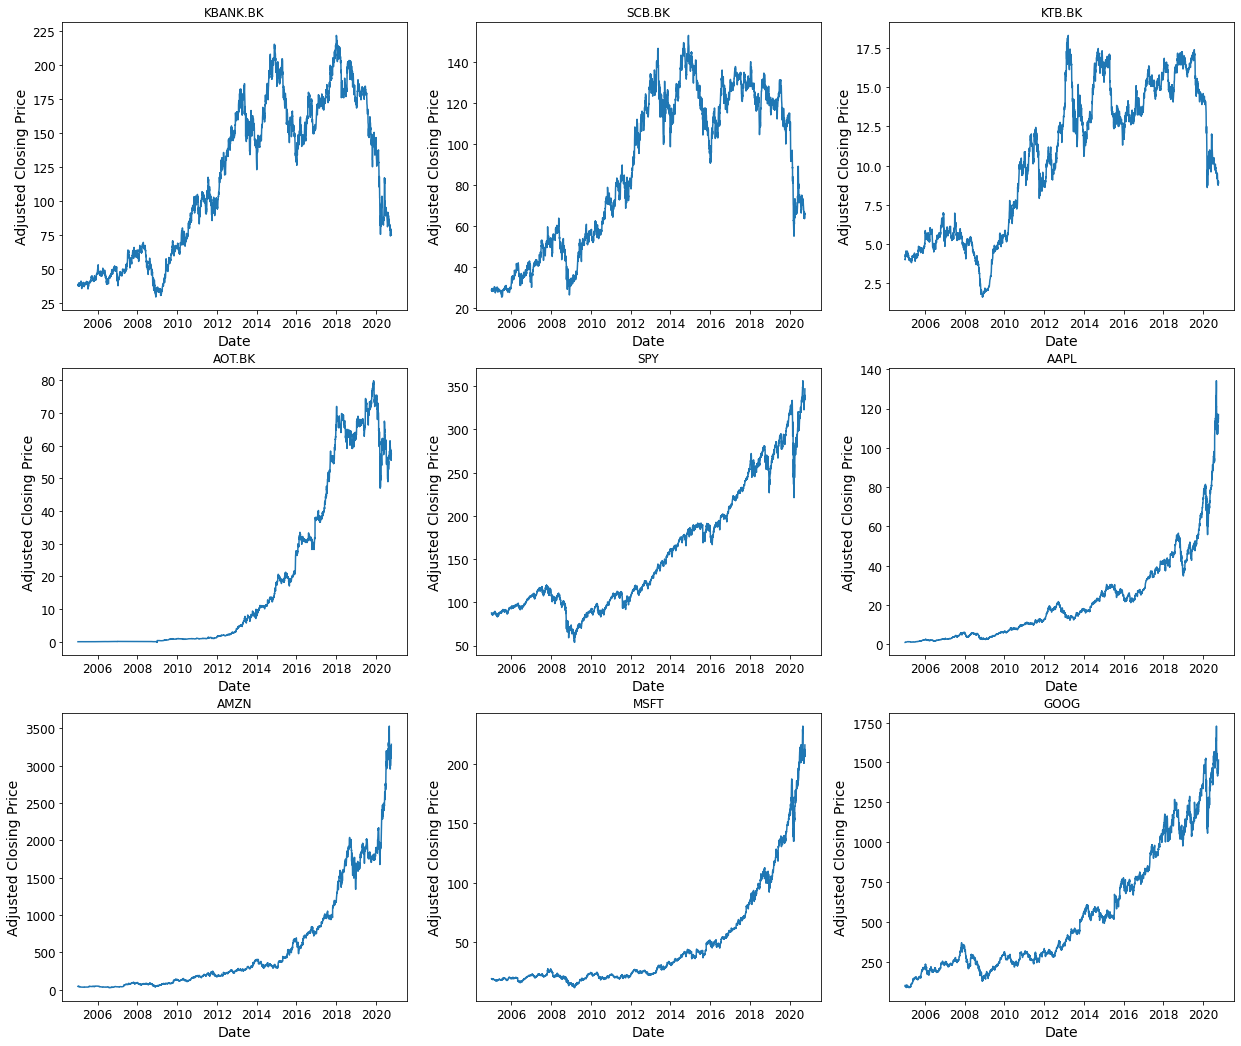

In [24]:
fig, axs = plt.subplots(3,3, figsize=(21,18))
axs = axs.ravel()

# plot adjusted closing price of all stocks
i = 0
for stock in stock_data:
  axs[i].plot(stock.index, stock["Adj Close"])
  axs[i].set_xlabel('Date')
  axs[i].set_ylabel('Adjusted Closing Price')
  axs[i].set_title(stock_names[i])
  i = i+1

Now we choose which stock we want to predict:

In [31]:
stock_chosen = 'AOT.BK' #@param ['KBANK.BK','SCB.BK','KTB.BK','AOT.BK','SPY','AAPL','AMZN','MSFT','GOOG']

In [42]:
index = stock_names.index(stock_chosen)
print(index)

3


In [33]:
len = (stock_data[index].shape)[0]
print(len)

3872


Next, we split the data into 3 sets - training, validation, testing.

In [36]:
# spit data into train/valid/test data (70/20/10)
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(2710, 1)
(774, 1)
(388, 1)


Now we scale the data to optimize the performance of our neural network:

In [37]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

for i in range(60, train_split):
    X_train.append(train_data_scaled[i-60:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-60:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-60:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(2650, 60)
(2650,)
(714, 60)
(714,)
(328, 60)
(2650, 60, 1)
(2650,)
(714, 60, 1)
(714,)
(328, 60, 1)


And we start building our neural network full of LSTM layers with some dropout:

In [38]:
model = Sequential()
# Adding LSTM layers with Dropout
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_valid, y_valid))

Epoch 1/100
83/83 [==============================] - 3s 30ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 2/100
83/83 [==============================] - 1s 16ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 3/100
83/83 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 4/100
83/83 [==============================] - 1s 15ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 5/100
83/83 [==============================] - 1s 16ms/step - loss: 9.9476e-04 - val_loss: 0.0017
Epoch 6/100
83/83 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 7/100
83/83 [==============================] - 1s 15ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 8/100
83/83 [==============================] - 1s 15ms/step - loss: 8.7294e-04 - val_loss: 0.0019
Epoch 9/100
83/83 [==============================] - 1s 16ms/step - loss: 9.4415e-04 - val_loss: 0.0032
Epoch 10/100
83/83 [==============================] - 1s 15ms/step - loss: 0.0010 - val_

And evaluate our model

In [39]:
model.evaluate(X_valid, y_valid)

23/23 [==============================] - 0s 7ms/step - loss: 5.5712e-04


0.0005571224610321224

Now we scale the remaining data (the ones we're going to predict)

In [44]:
dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

and predict the our test data set, which is the last 10 percent our data, and scale it back to its original values

In [93]:
y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

Finally, we plot our predictions versus actual historical data

In [102]:
# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()